# US (entire country)

In [0]:
from sklearn import linear_model, tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## For parametric fitting
from scipy import optimize

dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
## group by country, sum and transpose
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["US"].values, columns=["total"])

## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')
dtf


,total,new
2020-01-22,1,0.0
2020-01-23,1,0.0
2020-01-24,2,1.0
2020-01-25,2,0.0
2020-01-26,5,3.0
...,...,...
2020-06-04,1872660,21140.0
2020-06-05,1897380,24720.0
2020-06-06,1920061,22681.0
2020-06-07,1943647,23586.0


In [0]:
'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

## optimize from scipy
x = np.arange(len(dtf["total"]))
y = dtf["total"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[1.38028584e+01 9.60630964e+01 1.92019998e+06]


In [0]:
'''
Plot parametric fitting.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)


   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    

    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Number of cases')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Number of cases')

    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [0]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    start = '2020-06-02'
    
    ## index
    index = pd.date_range(start=start,periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

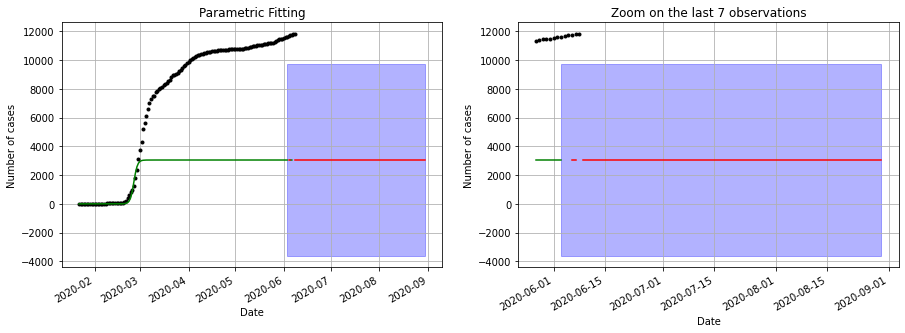

In [0]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve_check(ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    start = '2020-05-30'
    
    ## index
    index = pd.date_range(start=start,periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

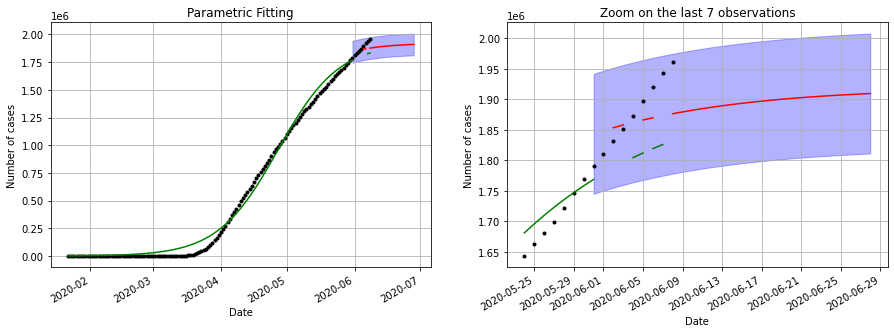

In [0]:
preds_check = forecast_curve_check(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=30, freq="D", zoom=7)

In [0]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y


X=np.arange(len(dtf["new"]))
Y=dtf["new"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

print(sigma)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model

24


array([3.06278351e+04, 9.88544962e+01, 2.88575302e+01])

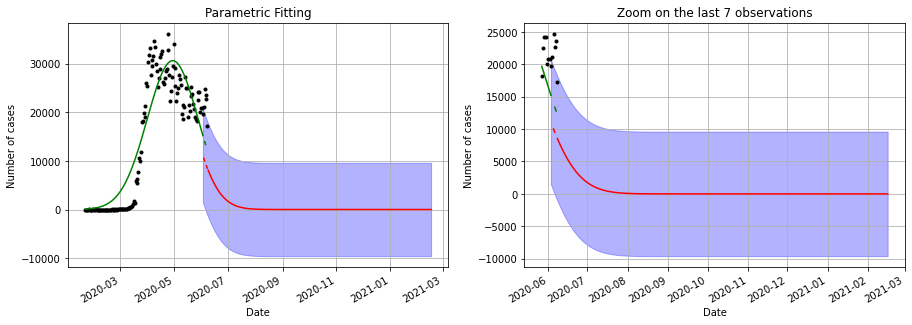

In [0]:
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)

# California

In [0]:
dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

dtf = dtf.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat','Long_', 'Combined_Key'], axis=1)
               
## group by state, sum and transpose
dtf = dtf.groupby("Province_State").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["California"].values, columns=["total"])

## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')
dtf

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,2,2.0
...,...,...
2020-06-04,122168,2820.0
2020-06-05,125738,3570.0
2020-06-06,128593,2855.0
2020-06-07,130615,2022.0


In [0]:
## optimize from scipy
x = np.arange(len(dtf["total"]))
y = dtf["total"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[1.76955971e+01 1.14599712e+02 1.60053513e+05]


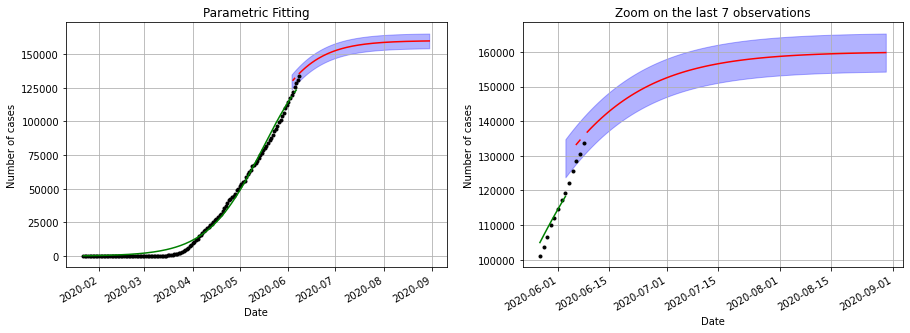

In [0]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

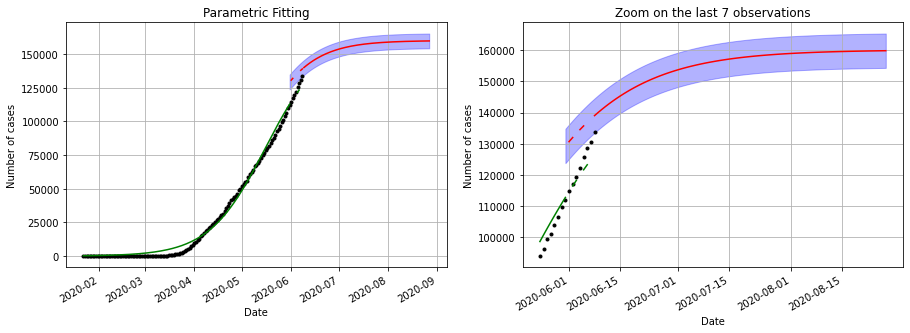

In [0]:
preds_check = forecast_curve_check(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
X=np.arange(len(dtf["new"]))
Y=dtf["new"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

print(sigma)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model


def specific_gaussian_function(model, X):
  y = model[0] * np.exp(-0.5 * ((X-model[1])/model[2])**2)
  return y
  
max_val = 0
max_date = 0
for x in range(500):
    y = specific_gaussian_function(gaussian_model, x)
    if (y>max_val):
      max_val = y
      max_date = x

print (max_val)
print (max_date)

61
2594.2047019192464
143


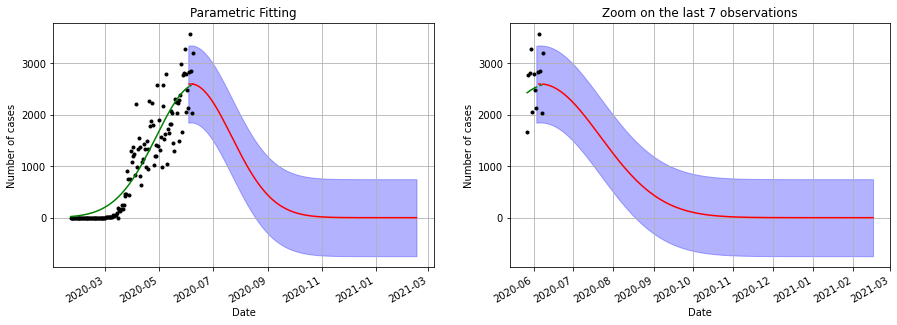

In [0]:
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)

# New York

In [0]:
dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

dtf = dtf.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat','Long_', 'Combined_Key'], axis=1)
               
## group by state, sum and transpose
dtf = dtf.groupby("Province_State").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf= pd.DataFrame(index=dtf.index, data=dtf["New York"].values, columns=["total"])

## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')
dtf

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0
...,...,...
2020-06-04,375133,1048.0
2020-06-05,376208,1075.0
2020-06-06,377316,1108.0
2020-06-07,378097,781.0


In [0]:
## optimize from scipy
x = np.arange(len(dtf["total"]))
y = dtf["total"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[9.34311071e+00 8.15542230e+01 3.62913725e+05]


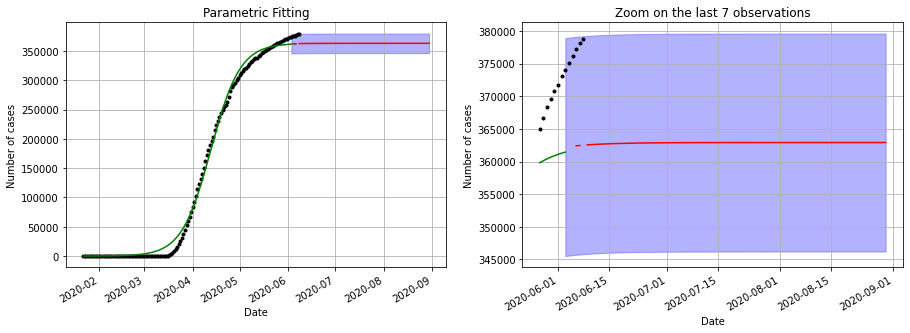

In [0]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

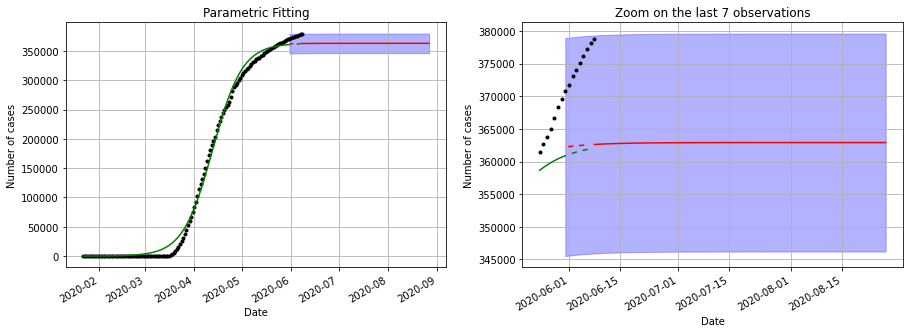

In [0]:
preds_check = forecast_curve_check(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y


X=np.arange(len(dtf["new"]))
Y=dtf["new"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

print(sigma)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model

max_val = 0
max_date = 0
for x in range(500):
    y = specific_gaussian_function(gaussian_model, x)
    if (y>max_val):
      max_val = y
      max_date = x

print (max_val)
print (max_date)

20
9313.942900022643
80


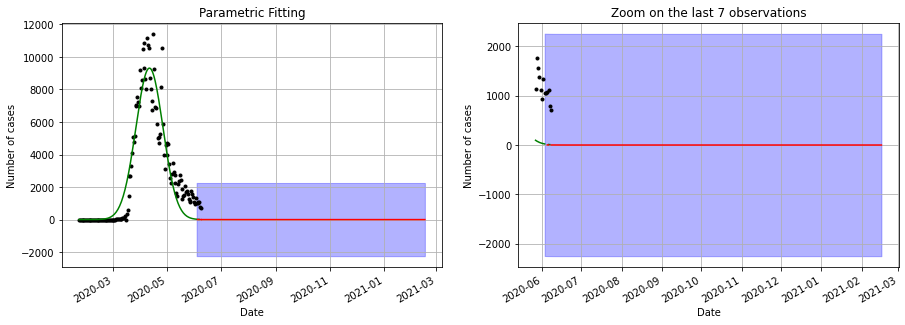

In [0]:
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)

# Iowa

In [0]:
dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

dtf = dtf.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat','Long_', 'Combined_Key'], axis=1)
               
## group by state, sum and transpose
dtf = dtf.groupby("Province_State").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["Iowa"].values, columns=["total"])

## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')
dtf

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0
...,...,...
2020-06-04,20806,506.0
2020-06-05,21154,348.0
2020-06-06,21478,324.0
2020-06-07,21712,234.0


In [0]:
## optimize from scipy
x = np.arange(len(dtf["total"]))
y = dtf["total"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[1.11971965e+01 1.07806870e+02 2.23520954e+04]


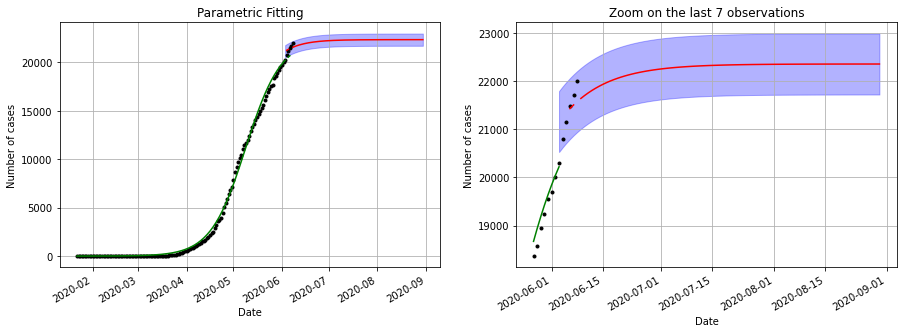

In [0]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

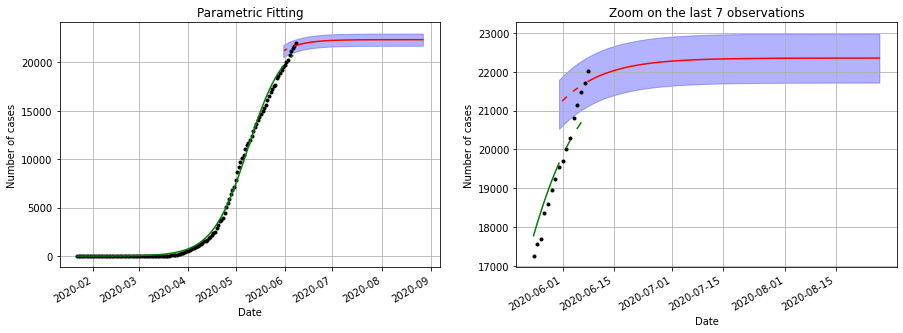

In [0]:
preds_check = forecast_curve_check(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
X=np.arange(len(dtf["new"]))
Y=dtf["new"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

print(sigma)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model

11


array([453.72695313, 110.07068136,  21.69146185])

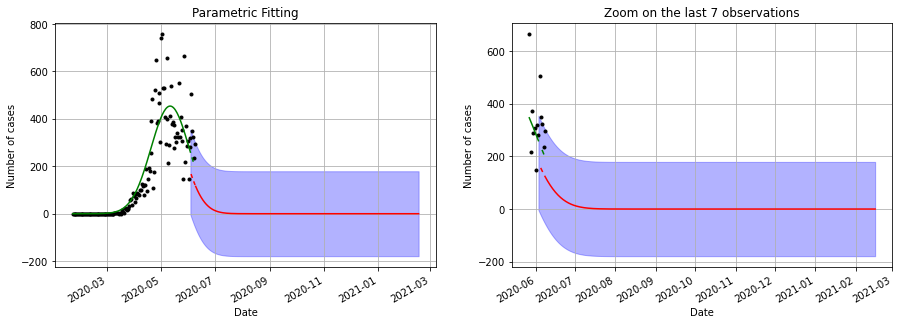

In [0]:
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)

# India active cases (total - recovered - deaths)

In [0]:
dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)
dtf = pd.DataFrame(index=dtf.index, data=dtf["India"].values, columns=["total"])

rec = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", sep=",")
rec = rec.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
rec.index = pd.to_datetime(rec.index, infer_datetime_format=True)
rec = pd.DataFrame(index=rec.index, data=rec["India"].values, columns=["recovered"])

deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", sep=",")
deaths = deaths.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
deaths = pd.DataFrame(index=deaths.index, data=deaths["India"].values, columns=["deaths"])

## create active cases column
dtf["active"] = dtf["total"] - rec["recovered"] - deaths["deaths"]
dtf["active"] = dtf["active"].fillna(method='bfill')

dtf


,total,active
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2020-06-04,226713,111900
2020-06-05,236184,116302
2020-06-06,246622,120981
2020-06-07,257486,126431


In [0]:
## optimize from scipy
x = np.arange(len(dtf["active"]))
y = dtf["active"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[1.64555528e+01 1.33052174e+02 2.16667723e+05]


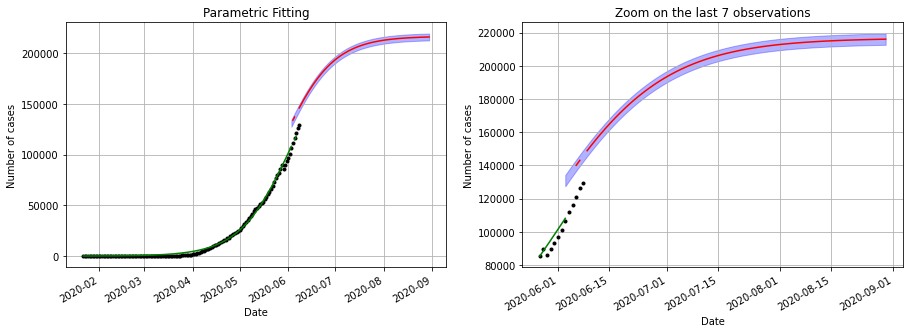

In [0]:
preds = forecast_curve(dtf["active"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
X=np.arange(len(dtf["active"]))
Y=dtf["active"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

print(sigma)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model

max_val = 0
max_date = 0
for x in range(500):
    y = specific_gaussian_function(gaussian_model, x)
    if (y>max_val):
      max_val = y
      max_date = x

print (max_val)
print (max_date)

14
237105.4908654923
182


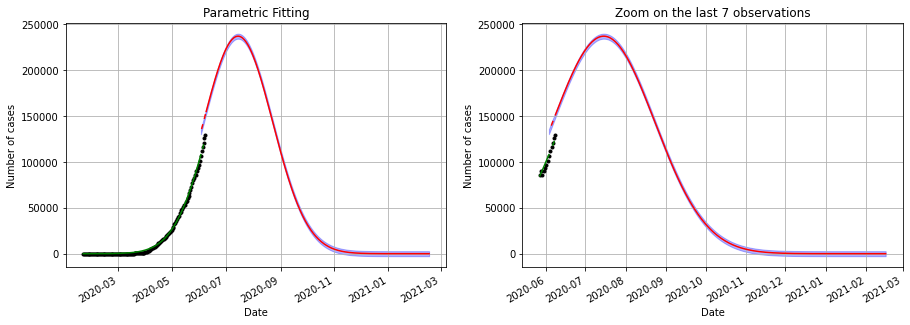

In [0]:
preds = forecast_curve(dtf["active"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)

# Saudi Arabia active cases (total - recovered - deaths)

In [0]:
dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)
dtf = pd.DataFrame(index=dtf.index, data=dtf["Saudi Arabia"].values, columns=["total"])

rec = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", sep=",")
rec = rec.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
rec.index = pd.to_datetime(rec.index, infer_datetime_format=True)
rec = pd.DataFrame(index=rec.index, data=rec["Saudi Arabia"].values, columns=["recovered"])

deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", sep=",")
deaths = deaths.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
deaths = pd.DataFrame(index=deaths.index, data=deaths["Saudi Arabia"].values, columns=["deaths"])

## create active cases column
dtf["active"] = dtf["total"] - rec["recovered"] - deaths["deaths"]
dtf["active"] = dtf["active"].fillna(method='bfill')

dtf

,total,active
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2020-06-04,93157,23581
2020-06-05,95748,24490
2020-06-06,98869,26402
2020-06-07,101914,28385


In [0]:
## optimize from scipy
x = np.arange(len(dtf["active"]))
y = dtf["active"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[5.62739051e+00 9.29674767e+01 2.70181729e+04]


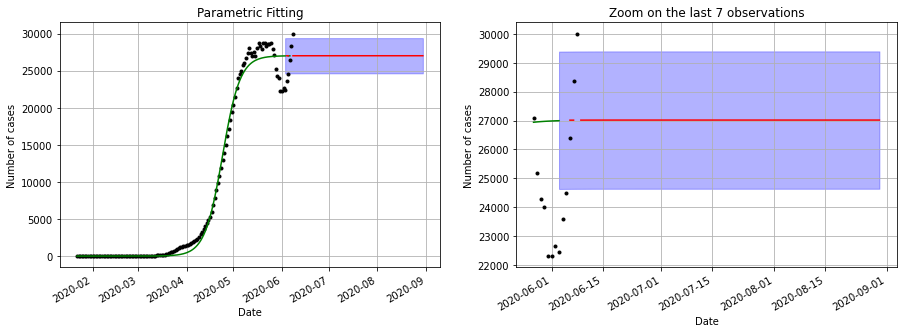

In [0]:
preds = forecast_curve(dtf["active"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
X=np.arange(len(dtf["active"]))
Y=dtf["active"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model


def specific_gaussian_function(model, X):
  y = model[0] * np.exp(-0.5 * ((X-model[1])/model[2])**2)
  return y

max_val = 0
max_date = 0
for x in range(500):
    y = specific_gaussian_function(gaussian_model, x)
    if (y>max_val):
      max_val = y
      max_date = x

print (max_val)
print (max_date)



29483.95548995549
120


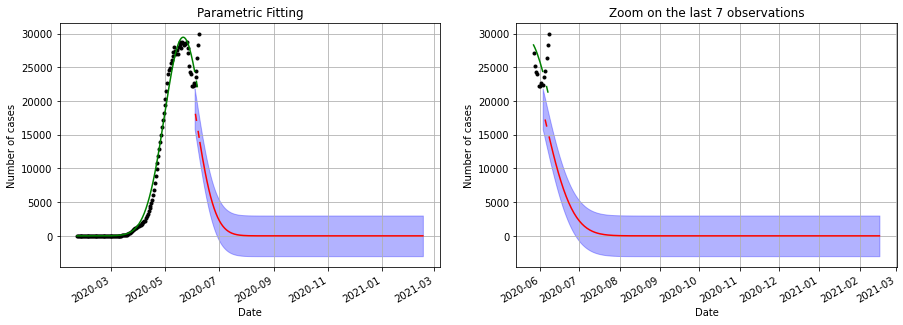

In [0]:
preds = forecast_curve(dtf["active"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)


# South Korea active cases (total - recovered - deaths)

In [0]:
dtf= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)
dtf = pd.DataFrame(index=dtf.index, data=dtf["Korea, South"].values, columns=["total"])

rec = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", sep=",")
rec = rec.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
rec.index = pd.to_datetime(rec.index, infer_datetime_format=True)
rec = pd.DataFrame(index=rec.index, data=rec["Korea, South"].values, columns=["recovered"])

deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", sep=",")
deaths = deaths.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T
deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
deaths = pd.DataFrame(index=deaths.index, data=deaths["Korea, South"].values, columns=["deaths"])

## create active cases column
dtf["active"] = dtf["total"] - rec["recovered"] - deaths["deaths"]
dtf["active"] = dtf["active"].fillna(method='bfill')

dtf

,total,active
2020-01-22,1,1
2020-01-23,1,1
2020-01-24,2,2
2020-01-25,2,2
2020-01-26,3,3
...,...,...
2020-06-04,11668,889
2020-06-05,11719,915
2020-06-06,11776,951
2020-06-07,11814,978


In [0]:
## optimize from scipy
x = np.arange(len(dtf["active"]))
y = dtf["active"].values

logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=x, 
                                ydata=y,p0=[1,1, 1])
# ## print the parameters
print(logistic_model)

[1.13651747e+00 3.50824511e+01 3.05053883e+03]


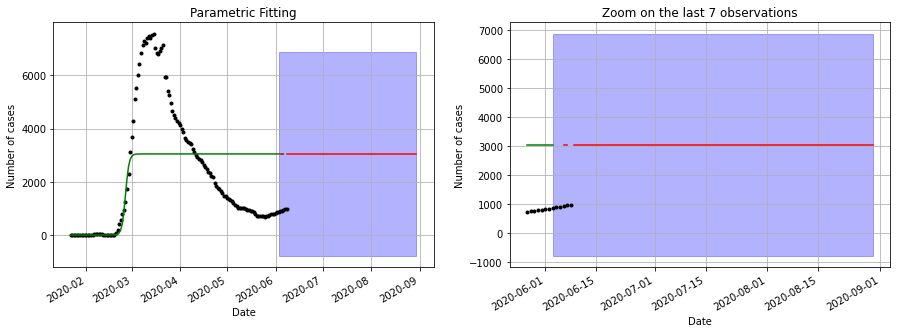

In [0]:
preds = forecast_curve(dtf["active"], logistic_f, logistic_model, 
                       pred_ahead=90, freq="D", zoom=7)

In [0]:
X=np.arange(len(dtf["active"]))
Y=dtf["active"].values

peak_value = Y.max()
mean = Y.argmax() # observation of the data shows that the peak is close to the center of the interval of the x-data
sigma = mean - np.where(Y > peak_value * np.exp(-.5))[0][0] # when x is sigma in the gaussian model, the function evaluates to a*exp(-.5)

print(sigma)

## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata = X, 
                                ydata= Y, maxfev=10000,
                                p0=[peak_value, mean, sigma])
## print the parameters
gaussian_model

12


array([6817.46361437,   57.28439068,   16.48318097])

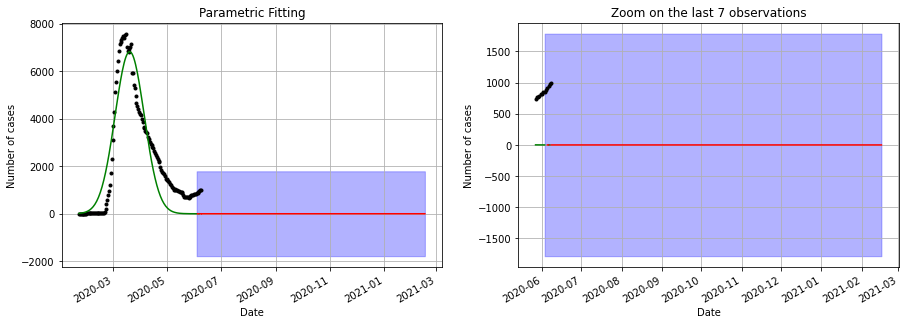

In [0]:
preds = forecast_curve(dtf["active"], gaussian_f, gaussian_model, 
                       pred_ahead=260, freq="D", zoom=7)

## Saudia Arabia Total Cases Logistic Curve

In [0]:
## group by country, sum and transpose
dtf_saudi =  pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf_saudi = dtf_saudi.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf_saudi.index = pd.to_datetime(dtf_saudi.index, infer_datetime_format=True)

## create total cases column
dtf_saudi = pd.DataFrame(index=dtf_saudi.index, data=dtf_saudi["Saudi Arabia"].values, columns=["total"])

# create new cases column
dtf_saudi["new"] = dtf_saudi["total"] - dtf_saudi["total"].shift(1)
dtf_saudi["new"] = dtf_saudi["new"].fillna(method='bfill')

x_saudi = np.arange(len(dtf_saudi["total"]))
y_saudi = dtf_saudi["total"].values

'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

logistic_model_saudi, cov_saudi = optimize.curve_fit(logistic_f,
                                xdata=x_saudi, 
                                ydata=y_saudi,p0=[1,1, 1])
# ## print the parameters
print(logistic_model_saudi)

[1.25758207e+01 1.18477767e+02 1.21965416e+05]


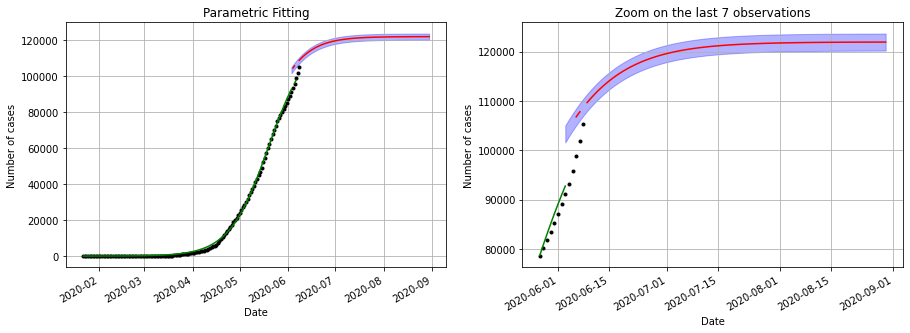

In [0]:
preds_saudi = forecast_curve(dtf_saudi["total"], logistic_f, logistic_model_saudi, 
                       pred_ahead=90, freq="D", zoom=7)

## India Total Cases Logistic Curve 

In [0]:
## group by country, sum and transpose
dtf_india =  pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf_india= dtf_india.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf_india.index = pd.to_datetime(dtf_india.index, infer_datetime_format=True)

## create total cases column
dtf_india = pd.DataFrame(index=dtf_india.index, data=dtf_india["India"].values, columns=["total"])

# create new cases column
dtf_india["new"] = dtf_india["total"] - dtf_saudi["total"].shift(1)
dtf_india["new"] = dtf_india["new"].fillna(method='bfill')

x_india = np.arange(len(dtf_india["total"]))
y_india = dtf_india["total"].values

'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

logistic_model_india, cov_india = optimize.curve_fit(logistic_f,
                                xdata=x_india, 
                                ydata=y_india,p0=[1,1, 1])
# ## print the parameters
print(logistic_model_india)

[1.49830572e+01 1.39537866e+02 5.55218078e+05]


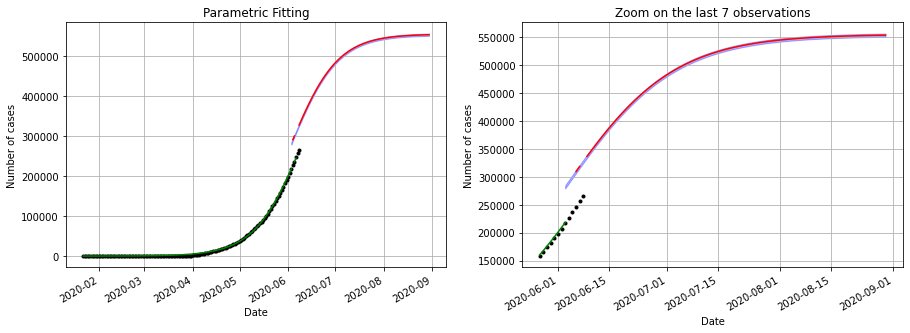

In [0]:
preds_india = forecast_curve(dtf_india["total"], logistic_f, logistic_model_india, 
                       pred_ahead=90, freq="D", zoom=7)